In [1]:
print("hello world")

hello world


In [2]:
GOOGLE_GENAI_USE_VERTEXAI="1"
GOOGLE_CLOUD_PROJECT="bq-gemini25waw-2001"
GOOGLE_CLOUD_LOCATION="us-central1"
BIGQUERY_DATASET_NAME="meetup0202"
BIGQUERY_LOCATION="us"
BIGQUERY_CONNECTION_NAME="meetup0202vertexbridge"
BIGQUERY_MODEL_OBJ_NAME="bqm_gemini25flash"
BIGQUERY_EMB_MODEL_OBJ_NAME="bqm_embgemini"
BIGQUERY_RESERVATION_NAME="bqmeetup"
SPANNER_INSTANCE_ID="merchantsearch"
SPANNER_DATABASE_ID="meetup"

## 1. Create BigQuery datastore

In [ ]:
RAW_SQL=f"""CREATE SCHEMA IF NOT EXISTS `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}`
OPTIONS(
  location='{BIGQUERY_LOCATION}'
);"""

print(RAW_SQL)

CREATE SCHEMA IF NOT EXISTS `bq-gemini25waw-2001.meetup0202`
OPTIONS(
  location='us'
);


## 2. Create tables by importing data files from local station



*   orders
*   products
*   social_media_comments



## 3. AI.FORECAST with Google TimesFM 2.5

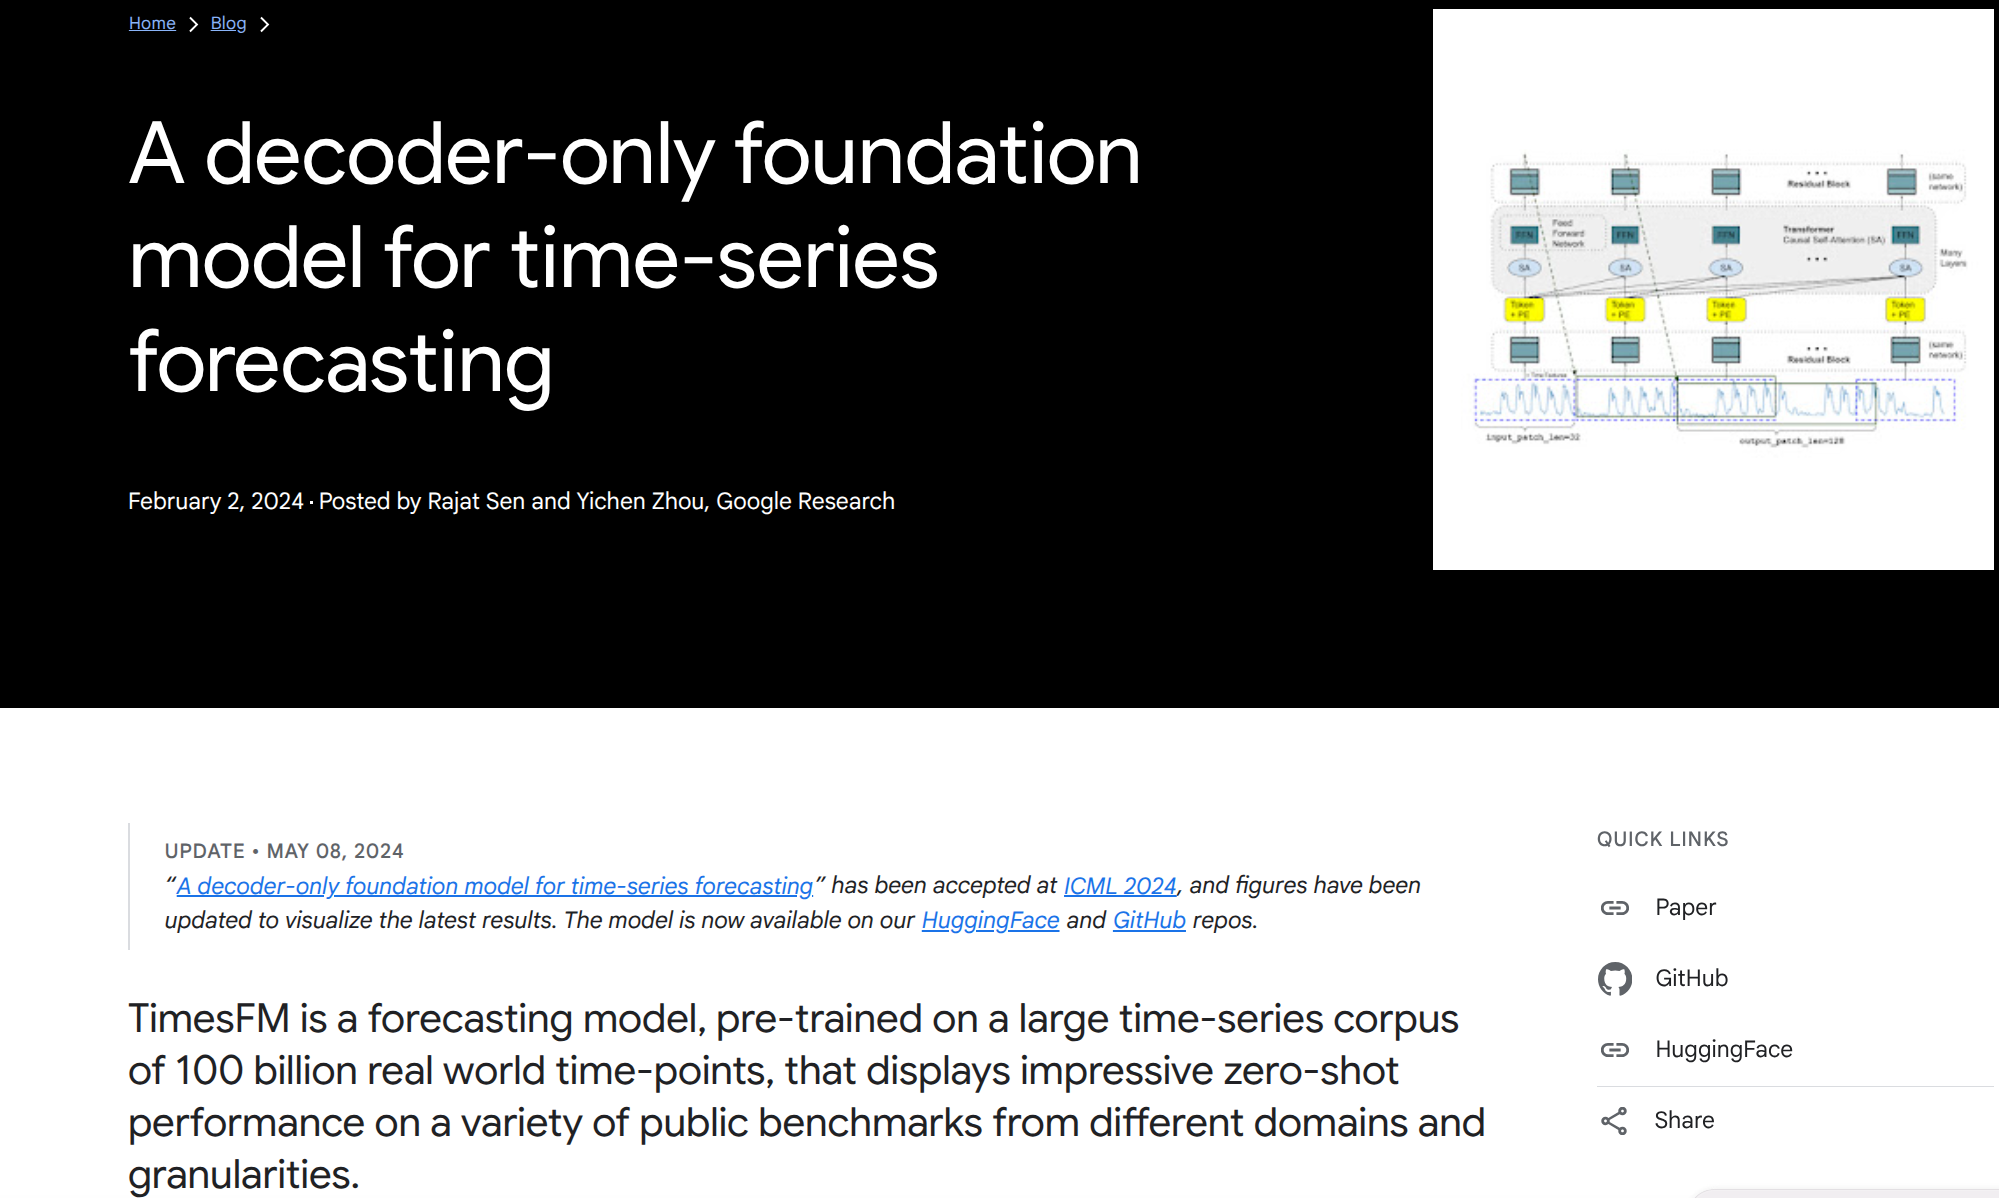

In [3]:
RAW_SQL=f"""
WITH
  historical_orders AS (
    SELECT EXTRACT(DATE FROM orders.order_date) AS order_day,
    COUNT(orders.order_id) AS number_of_orders
    FROM `{GOOGLE_CLOUD_PROJECT}`.`{BIGQUERY_DATASET_NAME}`.`orders` AS orders
    GROUP BY order_day
  )
SELECT * FROM AI.FORECAST(
    TABLE historical_orders,
    data_col => 'number_of_orders',
    timestamp_col => 'order_day',
    ##id_cols => ['usertype'],
    confidence_level => 0.95,
    output_historical_time_series => True,
    horizon => 64,
    context_window => 256
);
"""

print(RAW_SQL)


WITH
  historical_orders AS (
    SELECT EXTRACT(DATE FROM orders.order_date) AS order_day,
    COUNT(orders.order_id) AS number_of_orders
    FROM `bq-gemini25waw-2001`.`meetup0202`.`orders` AS orders
    GROUP BY order_day
  )
SELECT * FROM AI.FORECAST(
    TABLE historical_orders,
    data_col => 'number_of_orders',
    timestamp_col => 'order_day',
    ##id_cols => ['usertype'],
    confidence_level => 0.95,
    output_historical_time_series => True,
    horizon => 64,
    context_window => 256
);



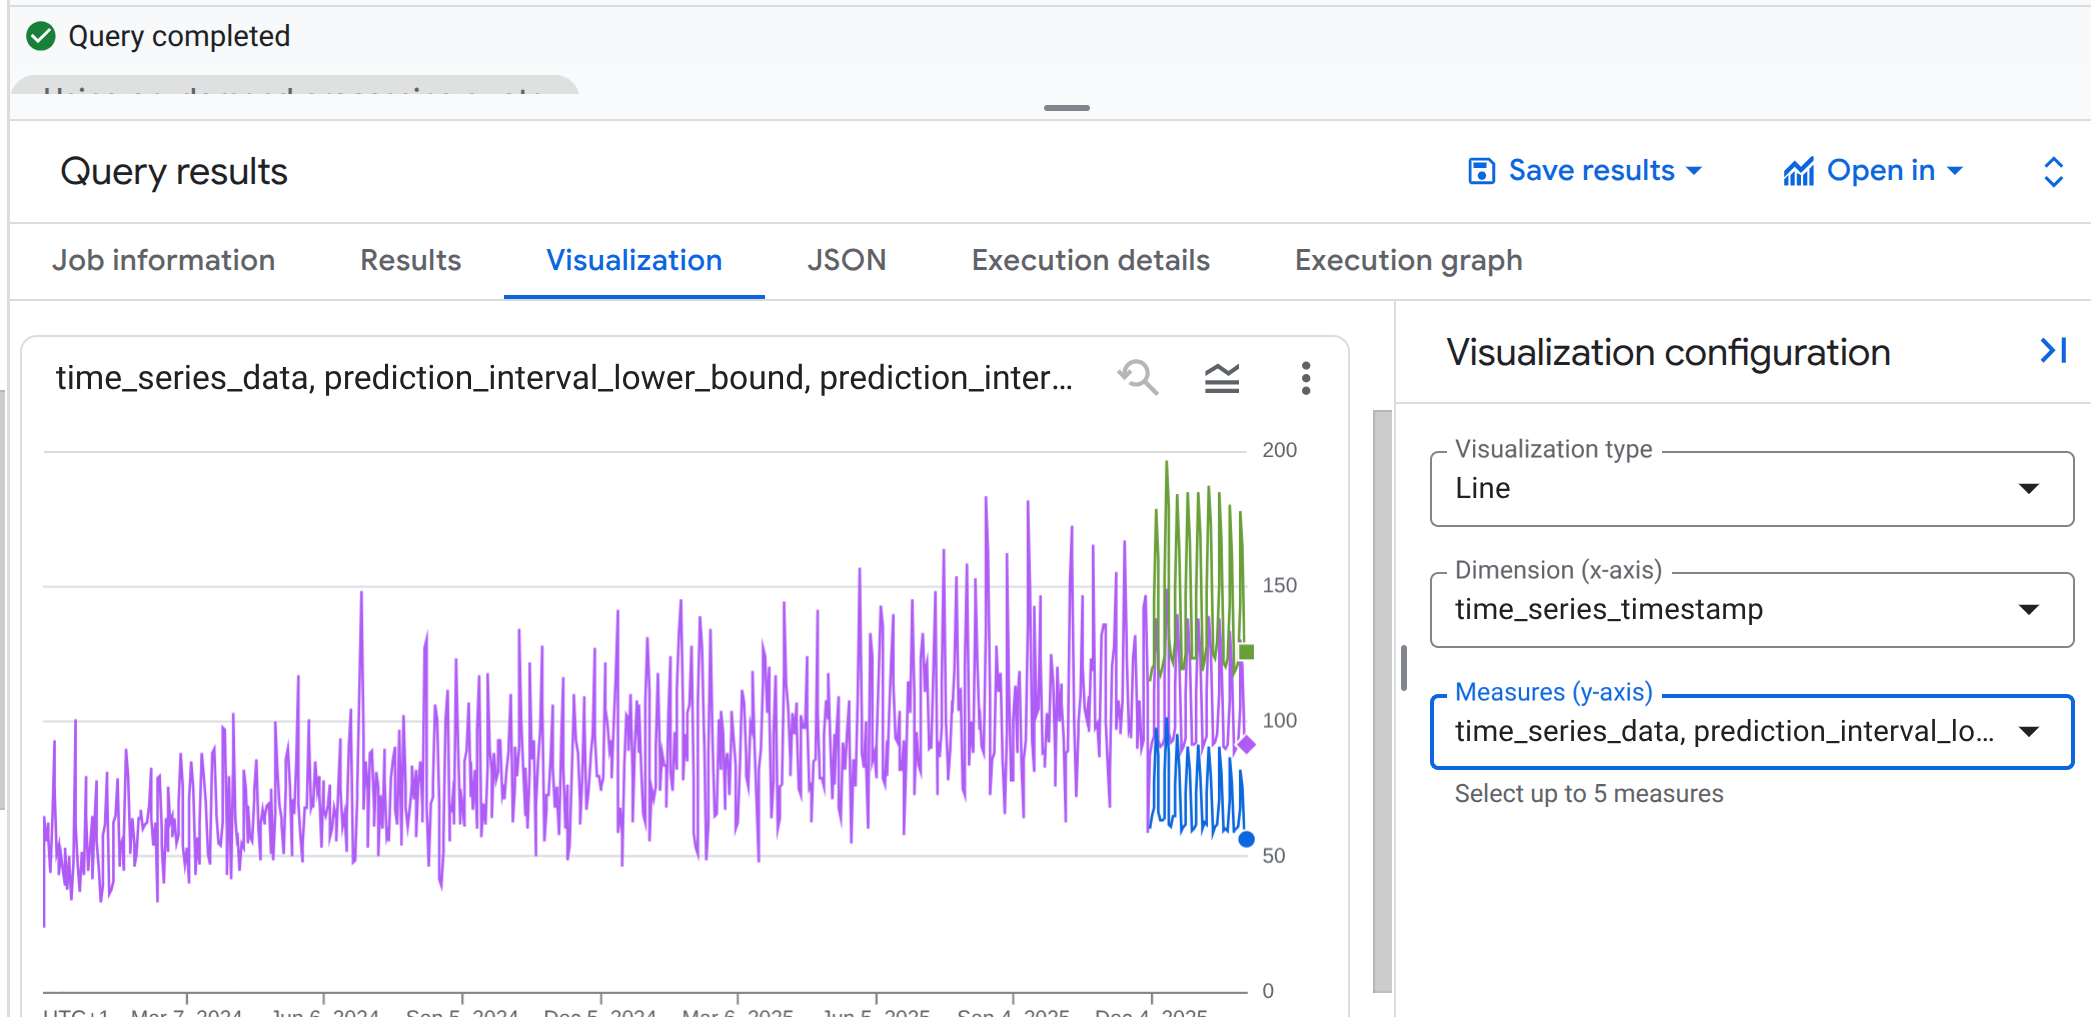

4. AI.EVALUATE

In [ ]:
RAW_SQL=f"""
WITH
  historical_orders AS (
    SELECT EXTRACT(DATE FROM orders.order_date) AS order_day,
    COUNT(orders.order_id) AS number_of_orders
    FROM `{GOOGLE_CLOUD_PROJECT}`.`{BIGQUERY_DATASET_NAME}`.`orders` AS orders
    GROUP BY order_day
  )
SELECT * FROM AI.EVALUATE(
    (SELECT * FROM historical_orders WHERE order_day < '2025-07-24'), #the name of the table that contains historical time series data which is used to generate a forecast.
    (SELECT * FROM historical_orders WHERE order_day >= '2025-07-24'), ## the name of the table that contains the actual time series data.
    model => 'TimesFM 2.5',
    data_col => 'number_of_orders',
    timestamp_col => 'order_day',
    ##id_cols => ['usertype'],
    horizon => 64
);
"""

print(RAW_SQL)


WITH
  historical_orders AS (
    SELECT EXTRACT(DATE FROM orders.order_date) AS order_day, 
    COUNT(orders.order_id) AS number_of_orders
    FROM `bq-gemini25waw-2001`.`meetup0202`.`orders` AS orders
    GROUP BY order_day
  )
SELECT * FROM AI.EVALUATE(
    (SELECT * FROM historical_orders WHERE order_day < '2025-07-24'), #the name of the table that contains historical time series data which is used to generate a forecast.
    (SELECT * FROM historical_orders WHERE order_day >= '2025-07-24'), ## the name of the table that contains the actual time series data.
    model => 'TimesFM 2.5',
    data_col => 'number_of_orders',
    timestamp_col => 'order_day',
    ##id_cols => ['usertype'],
    horizon => 64
);



## 5. Simple evaluation

In [ ]:
RAW_SQL=f"""
WITH -- 1. The Training Data (Data BEFORE the cutoff)
  historical_orders AS (
    SELECT
      EXTRACT(DATE FROM orders.order_date) AS order_day,
      COUNT(orders.order_id) AS number_of_orders
    FROM `{GOOGLE_CLOUD_PROJECT}`.`{BIGQUERY_DATASET_NAME}`.`orders` AS orders
    WHERE EXTRACT(DATE FROM orders.order_date) < '2025-07-24'
    GROUP BY order_day
  ),

  -- 2. The Actual Data (Data AFTER or ON the cutoff) for comparison
  actual_data AS (
    SELECT
      EXTRACT(DATE FROM orders.order_date) AS order_day,
      COUNT(orders.order_id) AS actual_orders_count
    FROM `{GOOGLE_CLOUD_PROJECT}`.`{BIGQUERY_DATASET_NAME}`.`orders` AS orders
    WHERE EXTRACT(DATE FROM orders.order_date) >= '2025-07-24'
    GROUP BY order_day
  ),

  -- 3. Run the Forecast Model
  forecast_results AS (
    SELECT * FROM AI.FORECAST(
      TABLE historical_orders,
      model => 'TimesFM 2.5',
      data_col => 'number_of_orders',
      timestamp_col => 'order_day',
      -- id_cols => ['usertype'], -- Uncomment if you use ID columns
      confidence_level => 0.95,
      output_historical_time_series => True,
      horizon => 64,
      context_window => 256
    )
  )

-- 4. Final Select: Join Forecast with Actuals
SELECT
  -- Cast the returned TIMESTAMP back to DATE to join with actuals
  DATE(f.time_series_timestamp) AS forecast_date,

  -- This column holds the 50% quantile (median) forecast
  f.time_series_data AS forecasted_value,

  a.actual_orders_count AS actual_value,

  -- Calculate deviation
  (f.time_series_data - a.actual_orders_count) as diff,

  f.prediction_interval_lower_bound,
  f.prediction_interval_upper_bound

FROM forecast_results f
LEFT JOIN actual_data a
  ON DATE(f.time_series_timestamp) = a.order_day
WHERE f.time_series_type = 'forecast' -- Filter out the 'history' rows
ORDER BY forecast_date ASC;
"""

print(RAW_SQL)


WITH -- 1. The Training Data (Data BEFORE the cutoff)
  historical_orders AS (
    SELECT 
      EXTRACT(DATE FROM orders.order_date) AS order_day, 
      COUNT(orders.order_id) AS number_of_orders
    FROM `bq-gemini25waw-2001`.`meetup0202`.`orders` AS orders
    WHERE EXTRACT(DATE FROM orders.order_date) < '2025-07-24'
    GROUP BY order_day
  ),

  -- 2. The Actual Data (Data AFTER or ON the cutoff) for comparison
  actual_data AS (
    SELECT 
      EXTRACT(DATE FROM orders.order_date) AS order_day, 
      COUNT(orders.order_id) AS actual_orders_count
    FROM `bq-gemini25waw-2001`.`meetup0202`.`orders` AS orders
    WHERE EXTRACT(DATE FROM orders.order_date) >= '2025-07-24'
    GROUP BY order_day
  ),

  -- 3. Run the Forecast Model
  forecast_results AS (
    SELECT * FROM AI.FORECAST(
      TABLE historical_orders,
      model => 'TimesFM 2.5',
      data_col => 'number_of_orders',
      timestamp_col => 'order_day',
      -- id_cols => ['usertype'], -- Uncomment if you use ID 

## Detect anomalies

In [ ]:
RAW_SQL=f"""
WITH
  historical_orders AS (
    SELECT EXTRACT(DATE FROM orders.order_date) AS order_day, 
    COUNT(orders.order_id) AS number_of_orders
    FROM `{GOOGLE_CLOUD_PROJECT}`.`{BIGQUERY_DATASET_NAME}`.`orders` AS orders
    GROUP BY order_day
  )
SELECT * FROM AI.DETECT_ANOMALIES(
    (SELECT * FROM historical_orders WHERE order_day < '2025-07-24'), #the name of the table that contains historical time series data which is used to generate a forecast.
    (SELECT * FROM historical_orders WHERE order_day >= '2025-07-24'), ## the name of the table that contains the actual time series data.
    model => 'TimesFM 2.5',
    data_col => 'number_of_orders',
    timestamp_col => 'order_day',
    ##id_cols => ['usertype'],
    anomaly_prob_threshold => 0.8
);
"""

print(RAW_SQL)

## * ADK agent

python -m venv myenv

source myenv/bin/activate

pip install google-adk

RUN: adk create helloworld

.env

In [ ]:
ENV_FILE=f"""
GOOGLE_GENAI_USE_VERTEXAI={GOOGLE_GENAI_USE_VERTEXAI}
GOOGLE_CLOUD_PROJECT={GOOGLE_CLOUD_PROJECT}
GOOGLE_CLOUD_LOCATION={GOOGLE_CLOUD_LOCATION}
"""

print(ENV_FILE)


GOOGLE_GENAI_USE_VERTEXAI=1
GOOGLE_CLOUD_PROJECT=bq-gemini25waw-2001
GOOGLE_CLOUD_LOCATION=us-central1



agent.py

In [ ]:
AGENT_RAW="""
import os
from dotenv import load_dotenv
from google.adk.agents import Agent
from google.genai import types
from google.adk.tools.bigquery import BigQueryToolset

load_dotenv()

MODEL = 'gemini-2.5-flash'
AGENT_APP_NAME = 'bqassistant'

bqtoolset = BigQueryToolset()

root_agent = Agent(
        model=MODEL,
        name=AGENT_APP_NAME,
        description="Use BigQUery tools to handle user queries",
        instruction="You are helpful BigQuery assistant",
        tools = [bqtoolset]
)
"""

print(AGENT_RAW)


import os
from dotenv import load_dotenv
from google.adk.agents import Agent
from google.genai import types
from google.adk.tools.bigquery import BigQueryToolset

load_dotenv()

MODEL = 'gemini-2.5-flash'
AGENT_APP_NAME = 'bqassistant'

bqtoolset = BigQueryToolset()

root_agent = Agent(
        model=MODEL,
        name=AGENT_APP_NAME,
        description="Use BigQUery tools to handle user queries",
        instruction="You are helpful BigQuery assistant",
        tools = [bqtoolset]
)



Test query:

In [ ]:
QUERY=f"""I want to use `{GOOGLE_CLOUD_PROJECT}`.`{BIGQUERY_DATASET_NAME}`.`orders` table.
Please aggregate the order_day column to a daily level and forecast the total count of orders for the next 30 days.
Please use {GOOGLE_CLOUD_PROJECT} project to run this query.
"""

print(QUERY)

I want to use `bq-gemini25waw-2001`.`meetup0202`.`orders` table. 
Please aggregate the order_day column to a daily level and forecast the total count of orders for the next 30 days. 
Please use bq-gemini25waw-2001 project to run this query.



## 6. AI.GENERATE

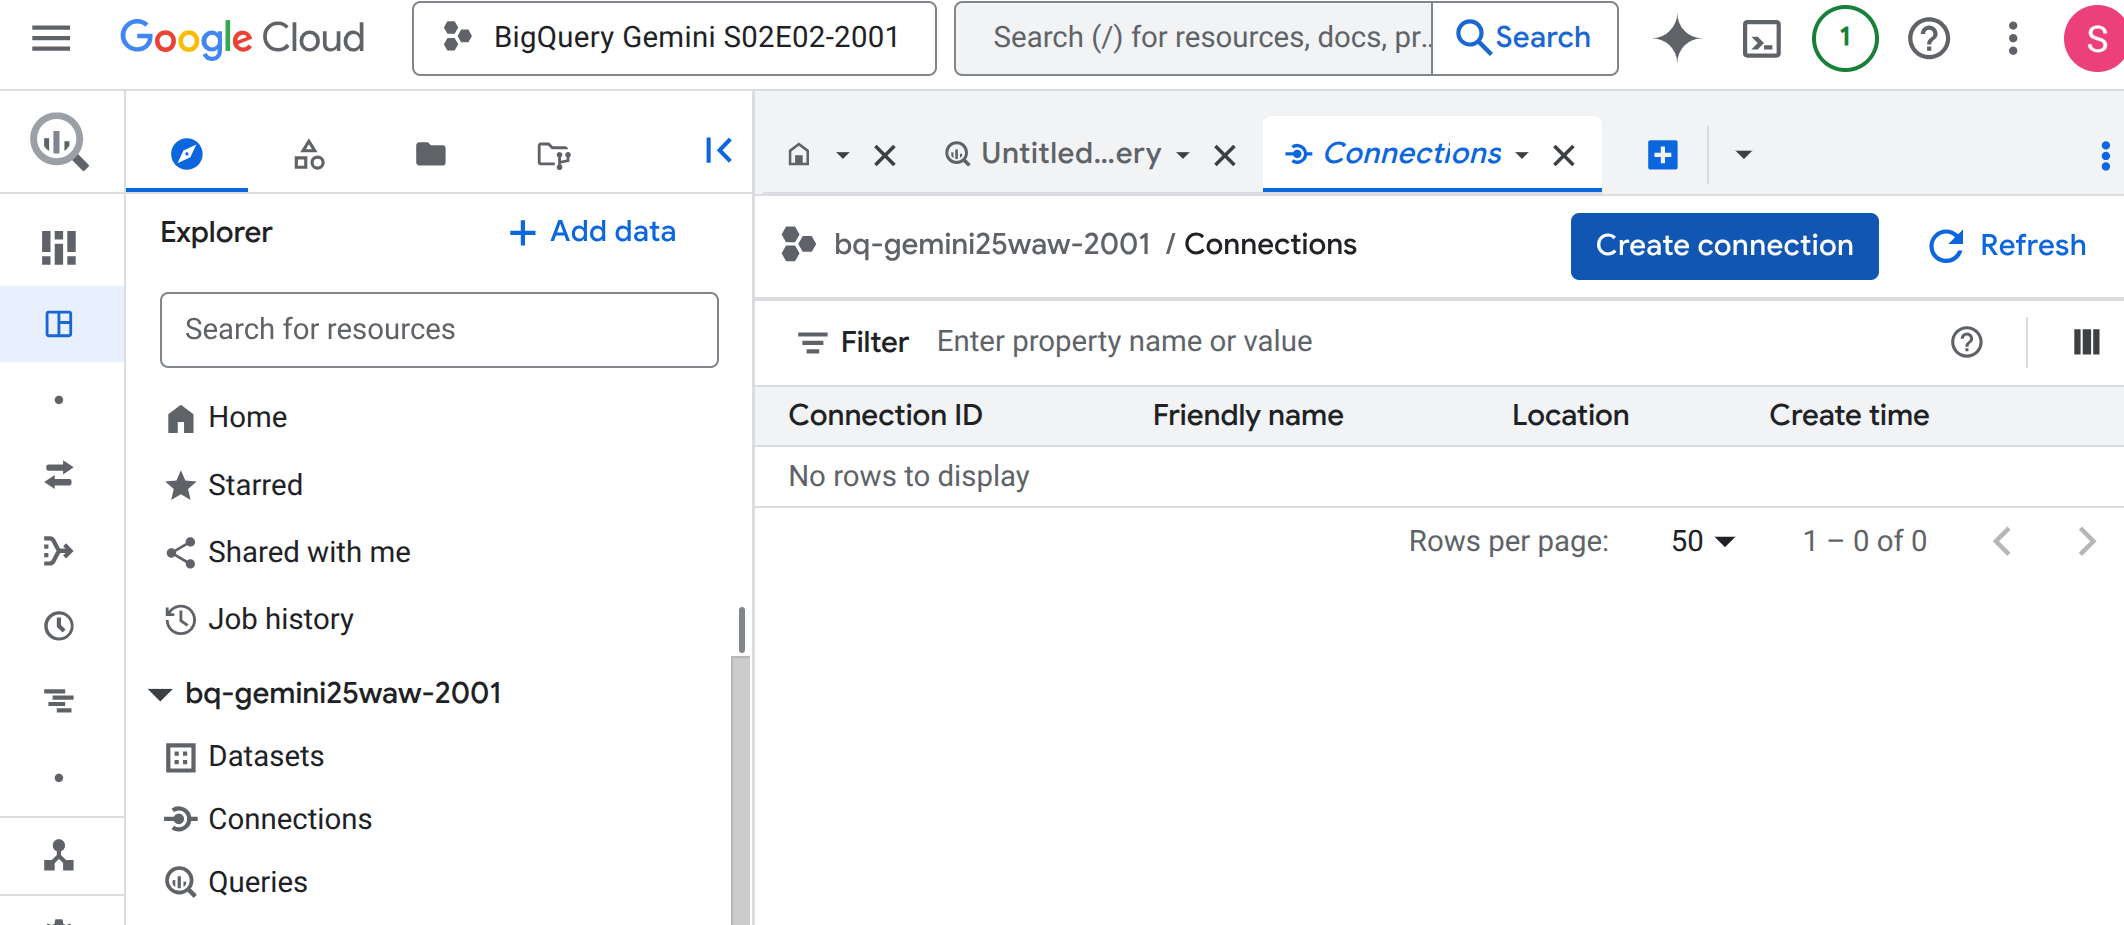

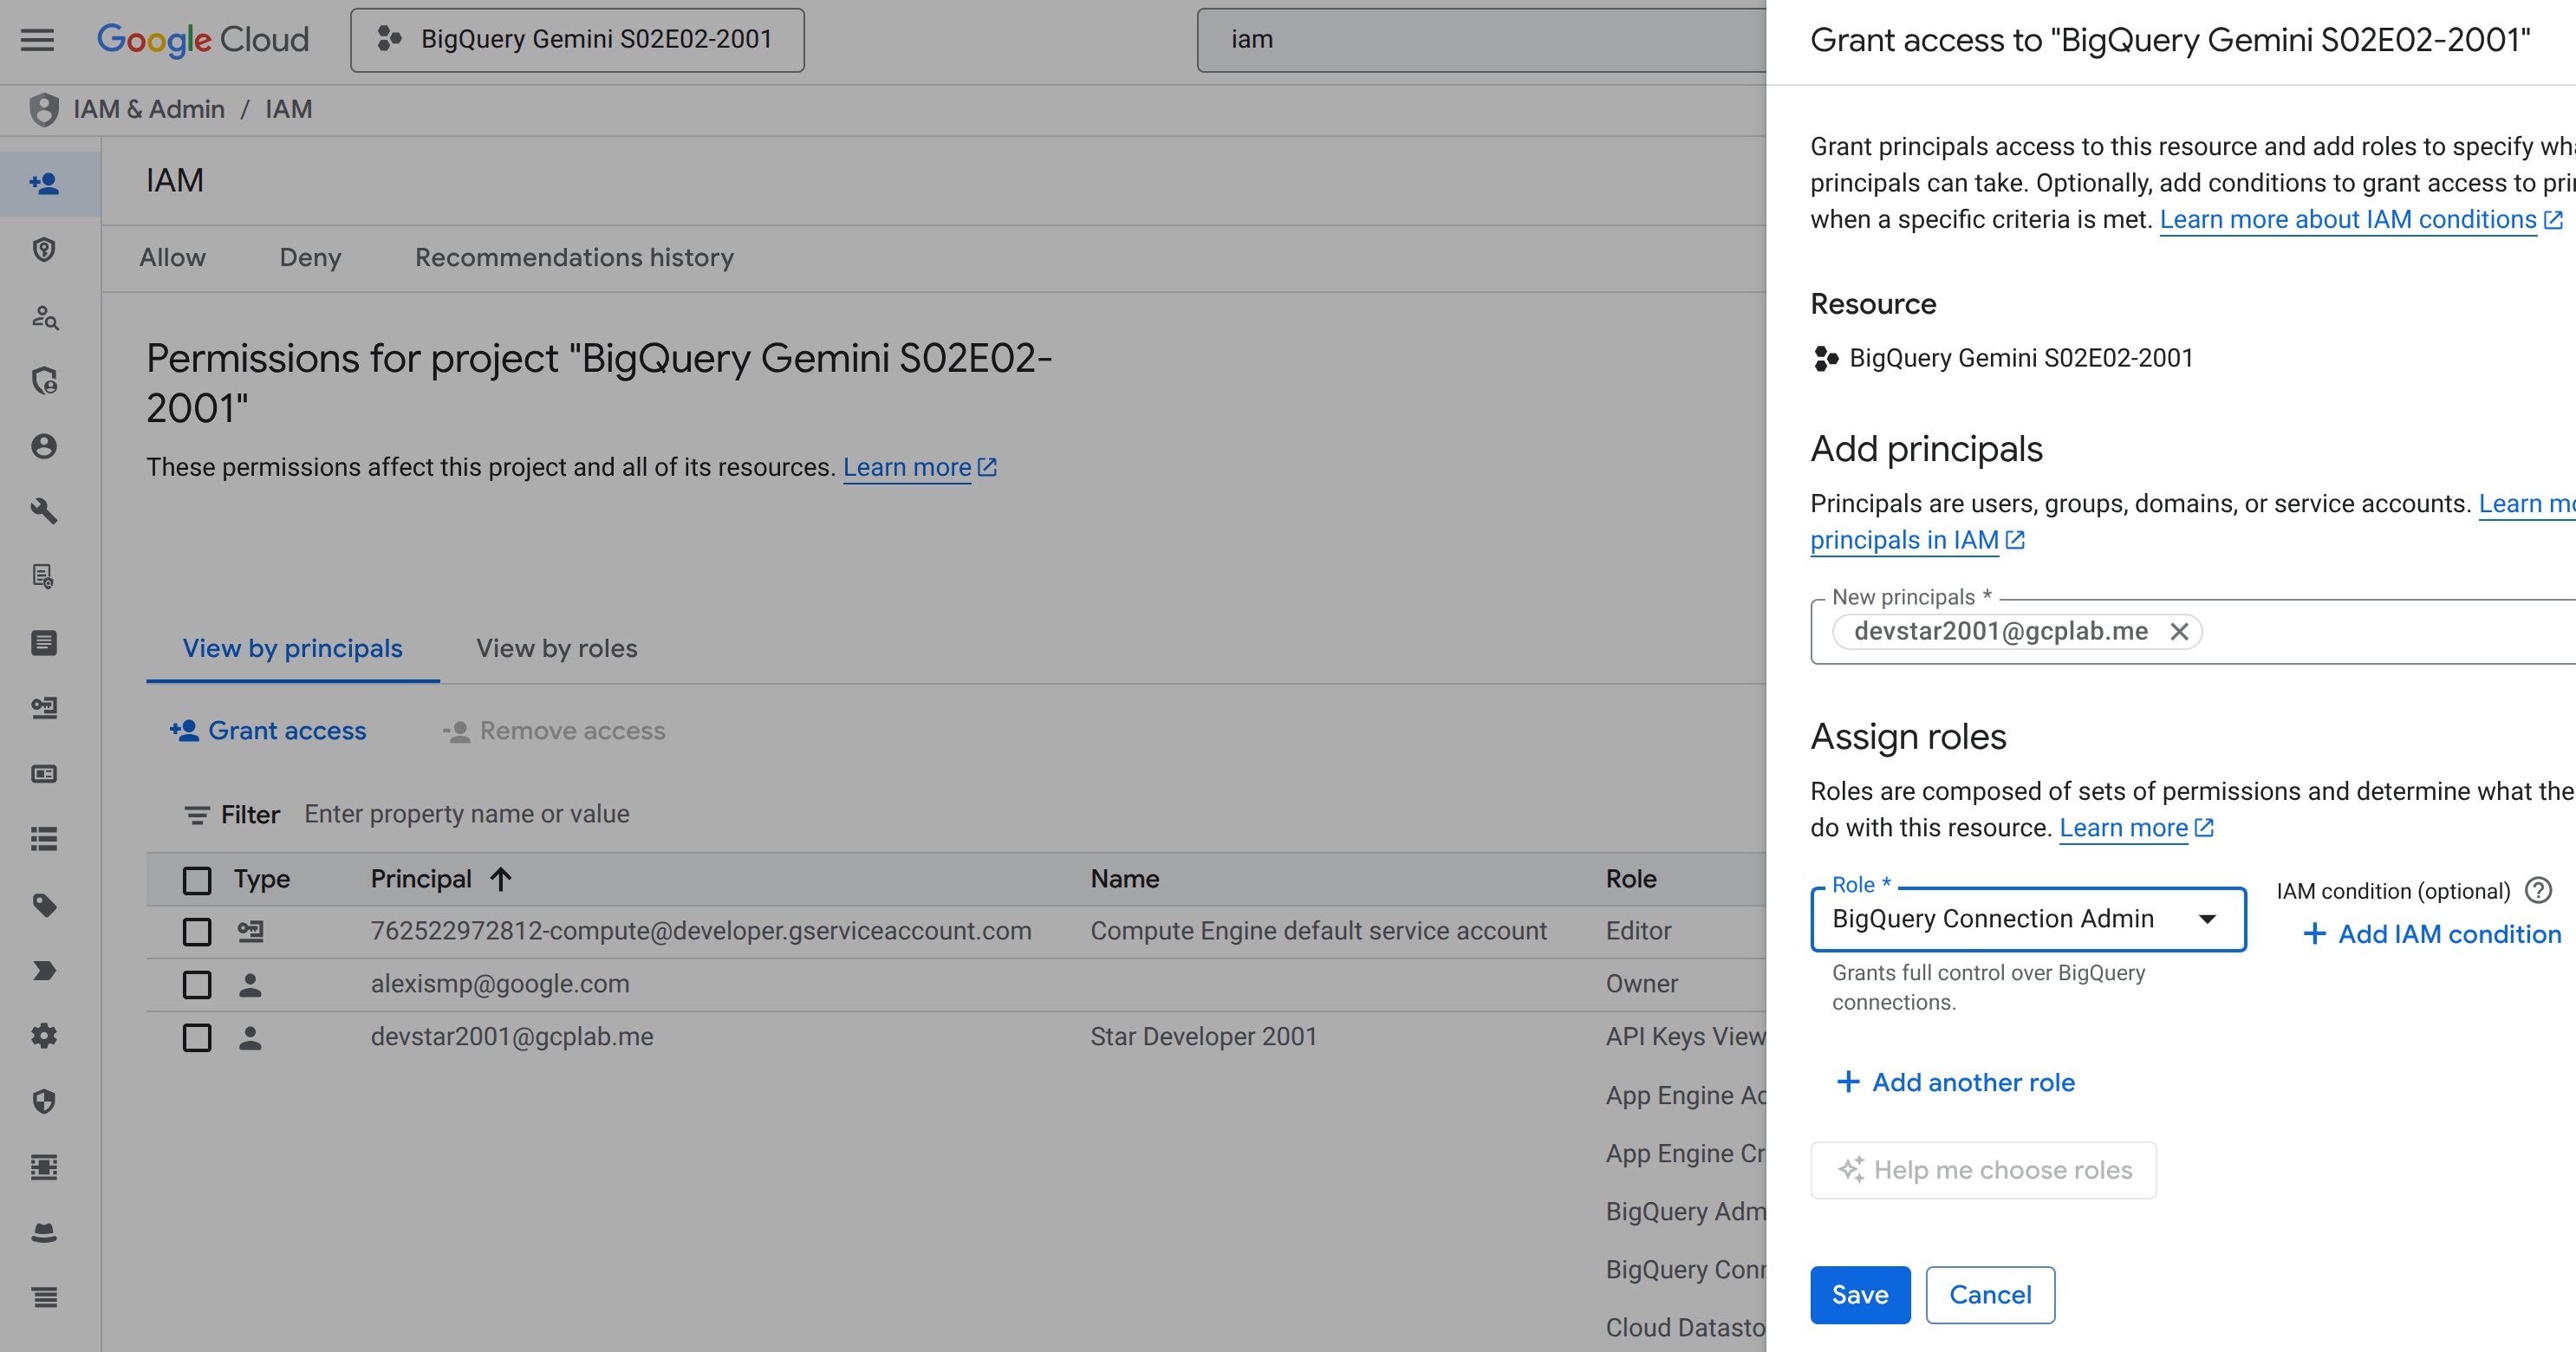

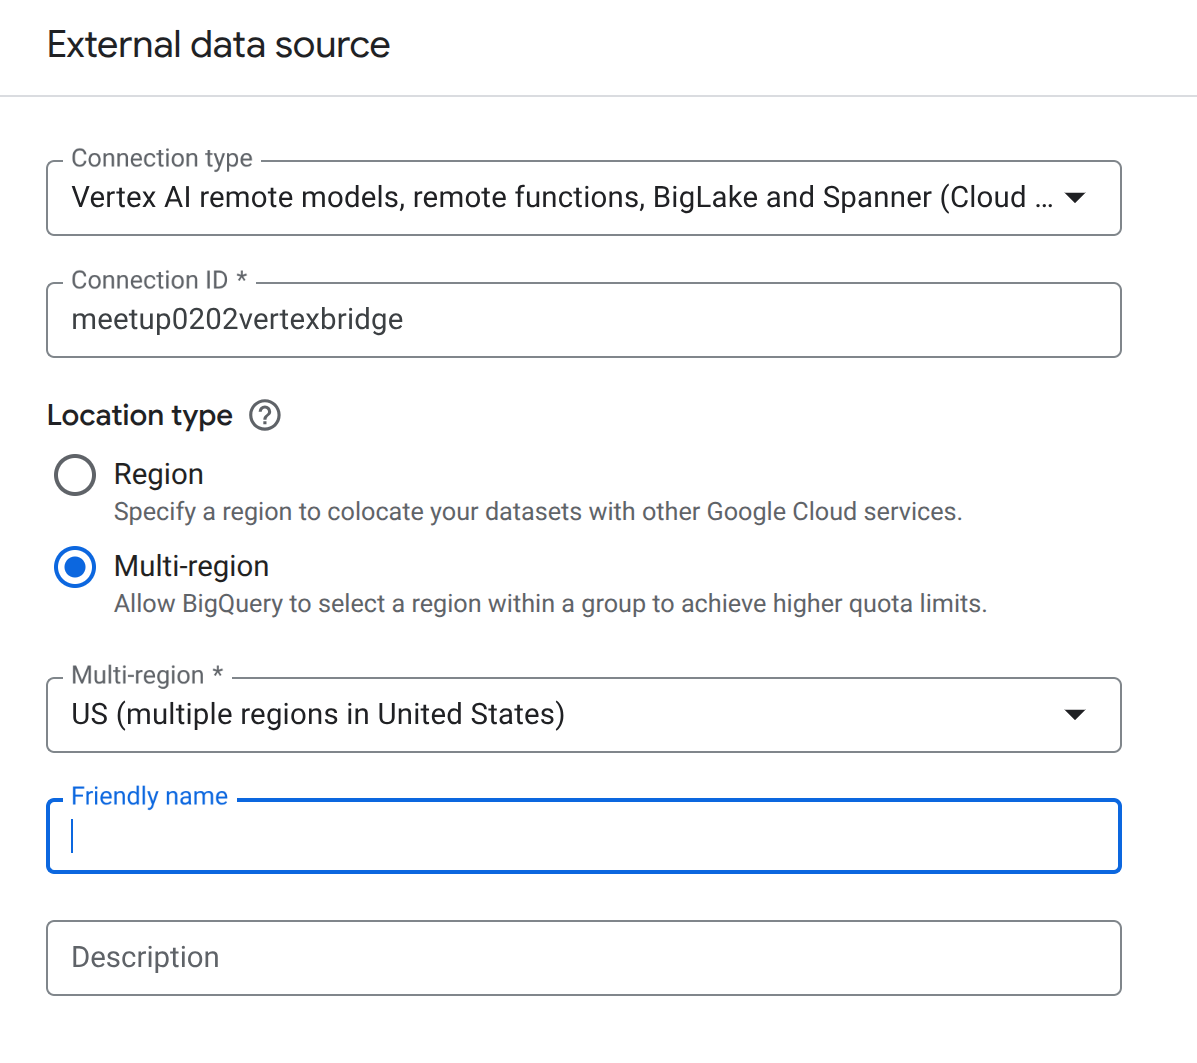

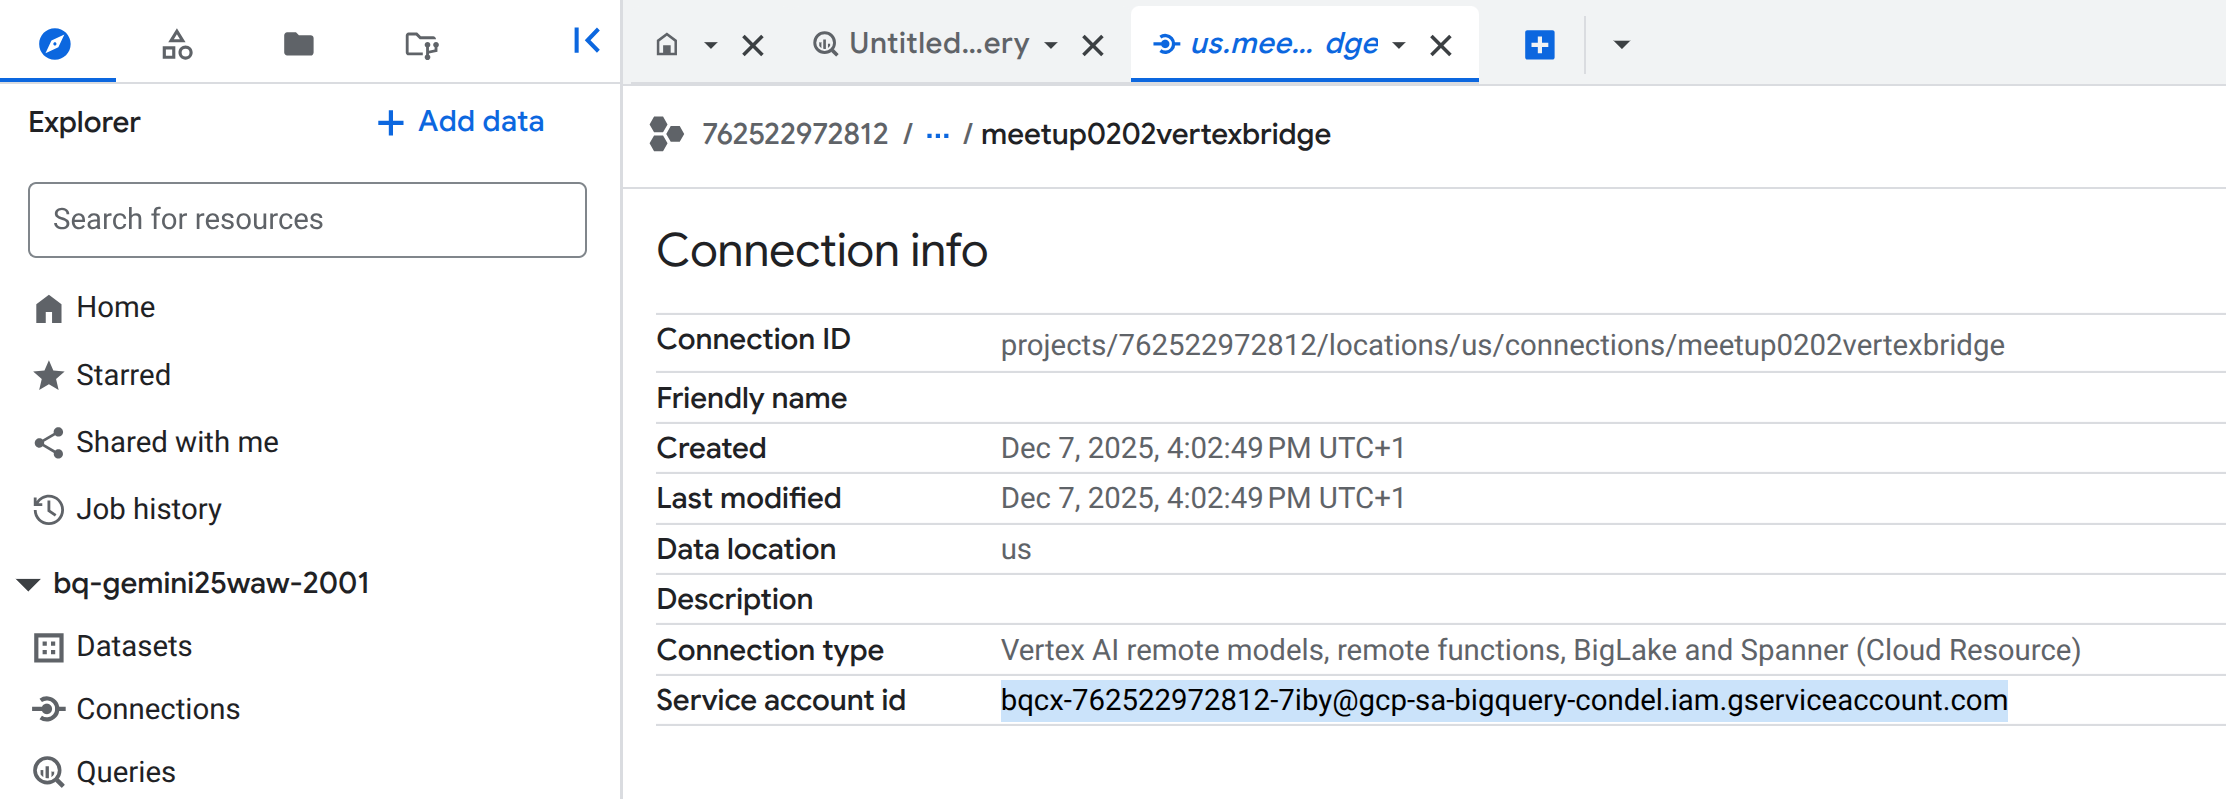

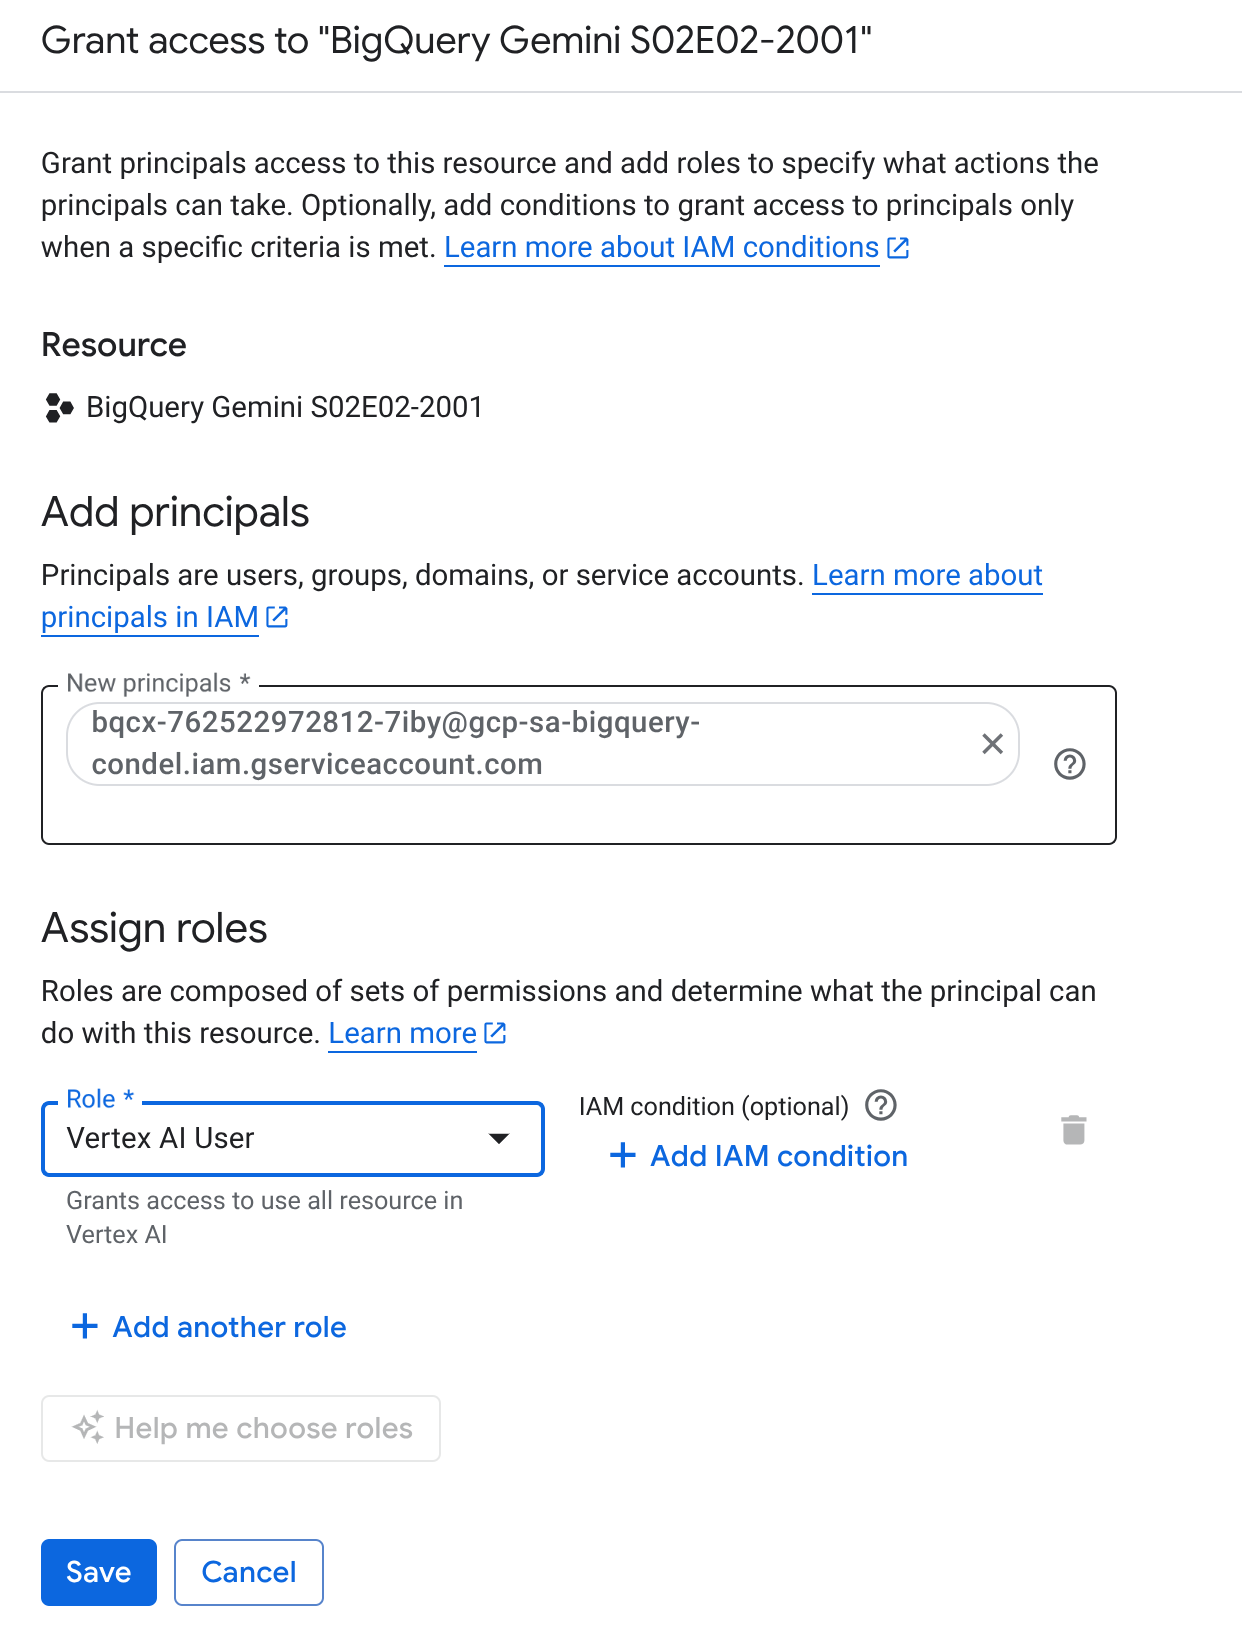

## 7. Create BigQuery model object representing Gemini 2.5 Flash

In [ ]:
MODEL_ENDPOINT="gemini-2.5-flash"

In [ ]:
RAW_SQL=f"""CREATE OR REPLACE MODEL `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.{BIGQUERY_MODEL_OBJ_NAME}`
REMOTE WITH CONNECTION `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_LOCATION}.{BIGQUERY_CONNECTION_NAME}`
OPTIONS(endpoint = '{MODEL_ENDPOINT}');"""

print(RAW_SQL)

CREATE OR REPLACE MODEL `bq-gemini25waw-2001.meetup0202.bqm_gemini25flash`
REMOTE WITH CONNECTION `bq-gemini25waw-2001.us.meetup0202vertexbridge`
OPTIONS(endpoint = 'gemini-2.5-flash');


## 8. AI.GENERATE response to comments on social media

In [ ]:
RAW_SQL=f"""SELECT AI.GENERATE(
  (
        'Act as a social media community manager. ',
        'Read the following comment: \"', comment_text, '\". ',
        'Draft a short, professional response following these rules: ',
        '1. Always thank the user for their comment. ',
        '2. Highlight the key observation they made. ',
        '3. IF the comment expresses dissatisfaction or unmet expectations, apologize sincerely and mention a specific short-term action we can consider to mitigate it. ',
        '4. Keep the tone empathetic and the length concise.',
        '5. Return single best draft without any additional comments'
  ),
  endpoint => 'gemini-2.5-flash'
) FROM `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.social_media_comments`;"""

print(RAW_SQL)

SELECT AI.GENERATE(
  (
        'Act as a social media community manager. ',
        'Read the following comment: "', comment_text, '". ',
        'Draft a short, professional response following these rules: ',
        '1. Always thank the user for their comment. ',
        '2. Highlight the key observation they made. ',
        '3. IF the comment expresses dissatisfaction or unmet expectations, apologize sincerely and mention a specific short-term action we can consider to mitigate it. ',
        '4. Keep the tone empathetic and the length concise.',
        '5. Return single best draft without any additional comments'
  ),
  endpoint => 'gemini-2.5-flash'
) FROM `bq-gemini25waw-2001.meetup0202.social_media_comments`;


## 8a the same with  AI.GENERATE_TEXT

In [ ]:
RAW_SQL=f"""SELECT * FROM AI.GENERATE_TEXT(
  -- 1. The Model
  MODEL `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.{BIGQUERY_MODEL_OBJ_NAME}`,
  -- 2. The Input Data (Constructing the Prompt)
  (
    SELECT
      comment_text, -- Pass original column through
      CONCAT(
        'Act as a social media community manager. ',
        'Read the following comment: \"', comment_text, '\". ',
        'Draft a short, professional response following these rules: ',
        '1. Always thank the user for their comment. ',
        '2. Highlight the key observation they made. ',
        '3. IF the comment expresses dissatisfaction or unmet expectations, apologize sincerely and mention a specific short-term action we can consider to mitigate it. ',
        '4. Keep the tone empathetic and the length concise.',
        '5. Return single best draft without any additional comments'
      ) AS prompt
    FROM `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.social_media_comments`
  ),
  -- 3. Model Parameters
  STRUCT(
   -- 0.2 AS temperature,        -- Low randomness for consistent, professional tone
   -- 0.8 AS top_p
   -- TRUE AS ground_with_google_search -- Optional
   )
);"""

print(RAW_SQL)

SELECT * FROM AI.GENERATE_TEXT(
  -- 1. The Model
  MODEL `bq-gemini25waw-2001.meetup0202.bqm_gemini25flash`,
  -- 2. The Input Data (Constructing the Prompt)
  (
    SELECT 
      comment_text, -- Pass original column through
      CONCAT(
        'Act as a social media community manager. ',
        'Read the following comment: "', comment_text, '". ',
        'Draft a short, professional response following these rules: ',
        '1. Always thank the user for their comment. ',
        '2. Highlight the key observation they made. ',
        '3. IF the comment expresses dissatisfaction or unmet expectations, apologize sincerely and mention a specific short-term action we can consider to mitigate it. ',
        '4. Keep the tone empathetic and the length concise.',
        '5. Return single best draft without any additional comments'
      ) AS prompt
    FROM `bq-gemini25waw-2001.meetup0202.social_media_comments`
  ),
  -- 3. Model Parameters
  STRUCT(
   -- 0.2 AS temperature,        

## 9. Extract key insights from data

In [ ]:
RAW_SQL=f"""
SELECT AI.GENERATE(
      (
        'Analyze the following social media comment: "', comment_text, '". ',
        'Extract the following information: ',
        '1. Product Name: The specific product mentioned. ',
        '2. Sentiment: The overall sentiment (Positive, Negative, Neutral). ',
        '3. Key Insights: Identify how the product generated a positive or bad experience, which features were mentioned, and any shopping experience details. ',
        'If the comment contains no relevant product or experience information, return empty list'
      ),
      output_schema => 'product_name STRING, sentiment STRING, key_insights ARRAY<STRING>',
      endpoint => 'gemini-2.5-flash'
    ).*
    FROM `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.social_media_comments`;"""

print(RAW_SQL)


SELECT AI.GENERATE(
      (
        'Analyze the following social media comment: "', comment_text, '". ',
        'Extract the following information: ',
        '1. Product Name: The specific product mentioned. ',
        '2. Sentiment: The overall sentiment (Positive, Negative, Neutral). ',
        '3. Key Insights: Identify how the product generated a positive or bad experience, which features were mentioned, and any shopping experience details. ',
        'If the comment contains no relevant product or experience information, return empty list'
      ),
      output_schema => 'product_name STRING, sentiment STRING, key_insights ARRAY<STRING>',
      endpoint => 'gemini-2.5-flash'
    ).* 
    FROM `bq-gemini25waw-2001.meetup0202.social_media_comments`;


9a. Same with AI.GENERATE_TABLE

In [ ]:
RAW_SQL=f"""
SELECT * FROM AI.GENERATE_TABLE(
  -- 1. The Model
  MODEL `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.{BIGQUERY_MODEL_OBJ_NAME}`,
  -- 2. The Input Data (Constructing the Prompt)
  (
    SELECT
      comment_text, -- Pass original column through
      CONCAT(
        'Analyze the following social media comment: \"', comment_text, '\". ',
        'Extract the following information: ',
        '1. Product Name: The specific product mentioned. ',
        '2. Sentiment: The overall sentiment (Positive, Negative, Neutral). ',
        '3. Key Insights: Identify how the product generated a positive or bad experience, which features were mentioned, and any shopping experience details. ',
        'If the comment contains no relevant product or experience information, return empty list'
      ) AS prompt
    FROM `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.social_media_comments`
  ),
  -- 3. Model Parameters & Output Schema
  STRUCT(
    -- Define the columns you want the model to generate
    '''
    product_name STRING,
    sentiment STRING,
    key_insights ARRAY<STRING>
    ''' AS output_schema
  )
);"""


print(RAW_SQL)


SELECT * FROM AI.GENERATE_TABLE(
  -- 1. The Model
  MODEL `bq-gemini25waw-2001.meetup0202.bqm_gemini25flash`,
  -- 2. The Input Data (Constructing the Prompt)
  (
    SELECT 
      comment_text, -- Pass original column through
      CONCAT(
        'Analyze the following social media comment: "', comment_text, '". ',
        'Extract the following information: ',
        '1. Product Name: The specific product mentioned. ',
        '2. Sentiment: The overall sentiment (Positive, Negative, Neutral). ',
        '3. Key Insights: Identify how the product generated a positive or bad experience, which features were mentioned, and any shopping experience details. ',
        'If the comment contains no relevant product or experience information, return empty list'
      ) AS prompt
    FROM `bq-gemini25waw-2001.meetup0202.social_media_comments`
  ),
  -- 3. Model Parameters & Output Schema
  STRUCT(
    -- Define the columns you want the model to generate
    '''
    product_name STRING,
   

## 10. AI.IF

In [ ]:
RAW_SQL=f"""
SELECT
  timestamp,
  comment_text,
  product_name,
  user_handle,
  product_id,
  comment_id
FROM `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.social_media_comments`
WHERE
  -- 1. Standard SQL Filter (Cost & Performance Optimization)
  -- Filter by platform first to reduce the number of rows sent to the AI model
  platform = 'Facebook'
  -- 2. AI Filter
  -- Uses the connection to evaluate the semantic meaning of the text
  AND AI.IF(
    ('Does this comment discuss camera? ', comment_text),
    connection_id => '{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_LOCATION}.{BIGQUERY_CONNECTION_NAME}'
  );"""

print(RAW_SQL)


SELECT 
  timestamp,
  comment_text,
  product_name,
  user_handle,
  product_id,
  comment_id
FROM `bq-gemini25waw-2001.meetup0202.social_media_comments`
WHERE 
  -- 1. Standard SQL Filter (Cost & Performance Optimization)
  -- Filter by platform first to reduce the number of rows sent to the AI model
  platform = 'Facebook'
  
  -- 2. AI Filter
  -- Uses the connection to evaluate the semantic meaning of the text
  AND AI.IF(
    ('Does this comment discuss camera? ', comment_text),
    connection_id => 'bq-gemini25waw-2001.us.meetup0202vertexbridge'
  );


## 11. Embedding model

In [ ]:
MODEL_ENDPOINT="gemini-embedding-001"

In [ ]:
RAW_SQL=f"""CREATE OR REPLACE MODEL `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.{BIGQUERY_EMB_MODEL_OBJ_NAME}`
REMOTE WITH CONNECTION `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_LOCATION}.{BIGQUERY_CONNECTION_NAME}`
OPTIONS(endpoint = '{MODEL_ENDPOINT}');"""

print(RAW_SQL)

CREATE OR REPLACE MODEL `bq-gemini25waw-2001.meetup0202.bqm_embgemini`
REMOTE WITH CONNECTION `bq-gemini25waw-2001.us.meetup0202vertexbridge`
OPTIONS(endpoint = 'gemini-embedding-001');


## 12. Generate embeddings AI.EMBED

In [ ]:
RAW_SQL=f"""
CREATE TABLE `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.products_indexed2` AS
  SELECT p.*,
  AI.EMBED(p.description,
      endpoint => 'gemini-embedding-001',
      task_type => 'SEMANTIC_SIMILARITY'
  ).result as product_embedding
  FROM `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.products` AS p
  WHERE description IS NOT NULL"""

print(RAW_SQL)


CREATE TABLE `bq-gemini25waw-2001.meetup0202.products_indexed2` AS
  SELECT p.*,  
  AI.EMBED(p.description, 
      endpoint => 'gemini-embedding-001', 
      task_type => 'SEMANTIC_SIMILARITY',
  ).result as product_embedding 
  FROM `bq-gemini25waw-2001.meetup0202.products` AS p
  WHERE description IS NOT NULL


## 13. Compute similarity with AI.SIMILARITY

In [5]:
SEARCH_TERM="wireless earbuds"
EMBEDDING_ENDPOINT="gemini-embedding-001"

In [6]:
RAW_SQL=f"""SELECT
  p.*,
  AI.SIMILARITY(
    '{SEARCH_TERM}', p.description, endpoint => '{EMBEDDING_ENDPOINT}')
    AS similarity_score
FROM `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.products` p
ORDER BY similarity_score DESC
LIMIT 5;"""

print(RAW_SQL)

SELECT
  p.*,
  AI.SIMILARITY(
    'wireless earbuds', p.description, endpoint => 'gemini-embedding-001')
    AS similarity_score
FROM `bq-gemini25waw-2001.meetup0202.products` p
ORDER BY similarity_score DESC
LIMIT 5;


## 15. Reverse ETL - export embeddings to Cloud Spanner

##15.1 Create spanner instance

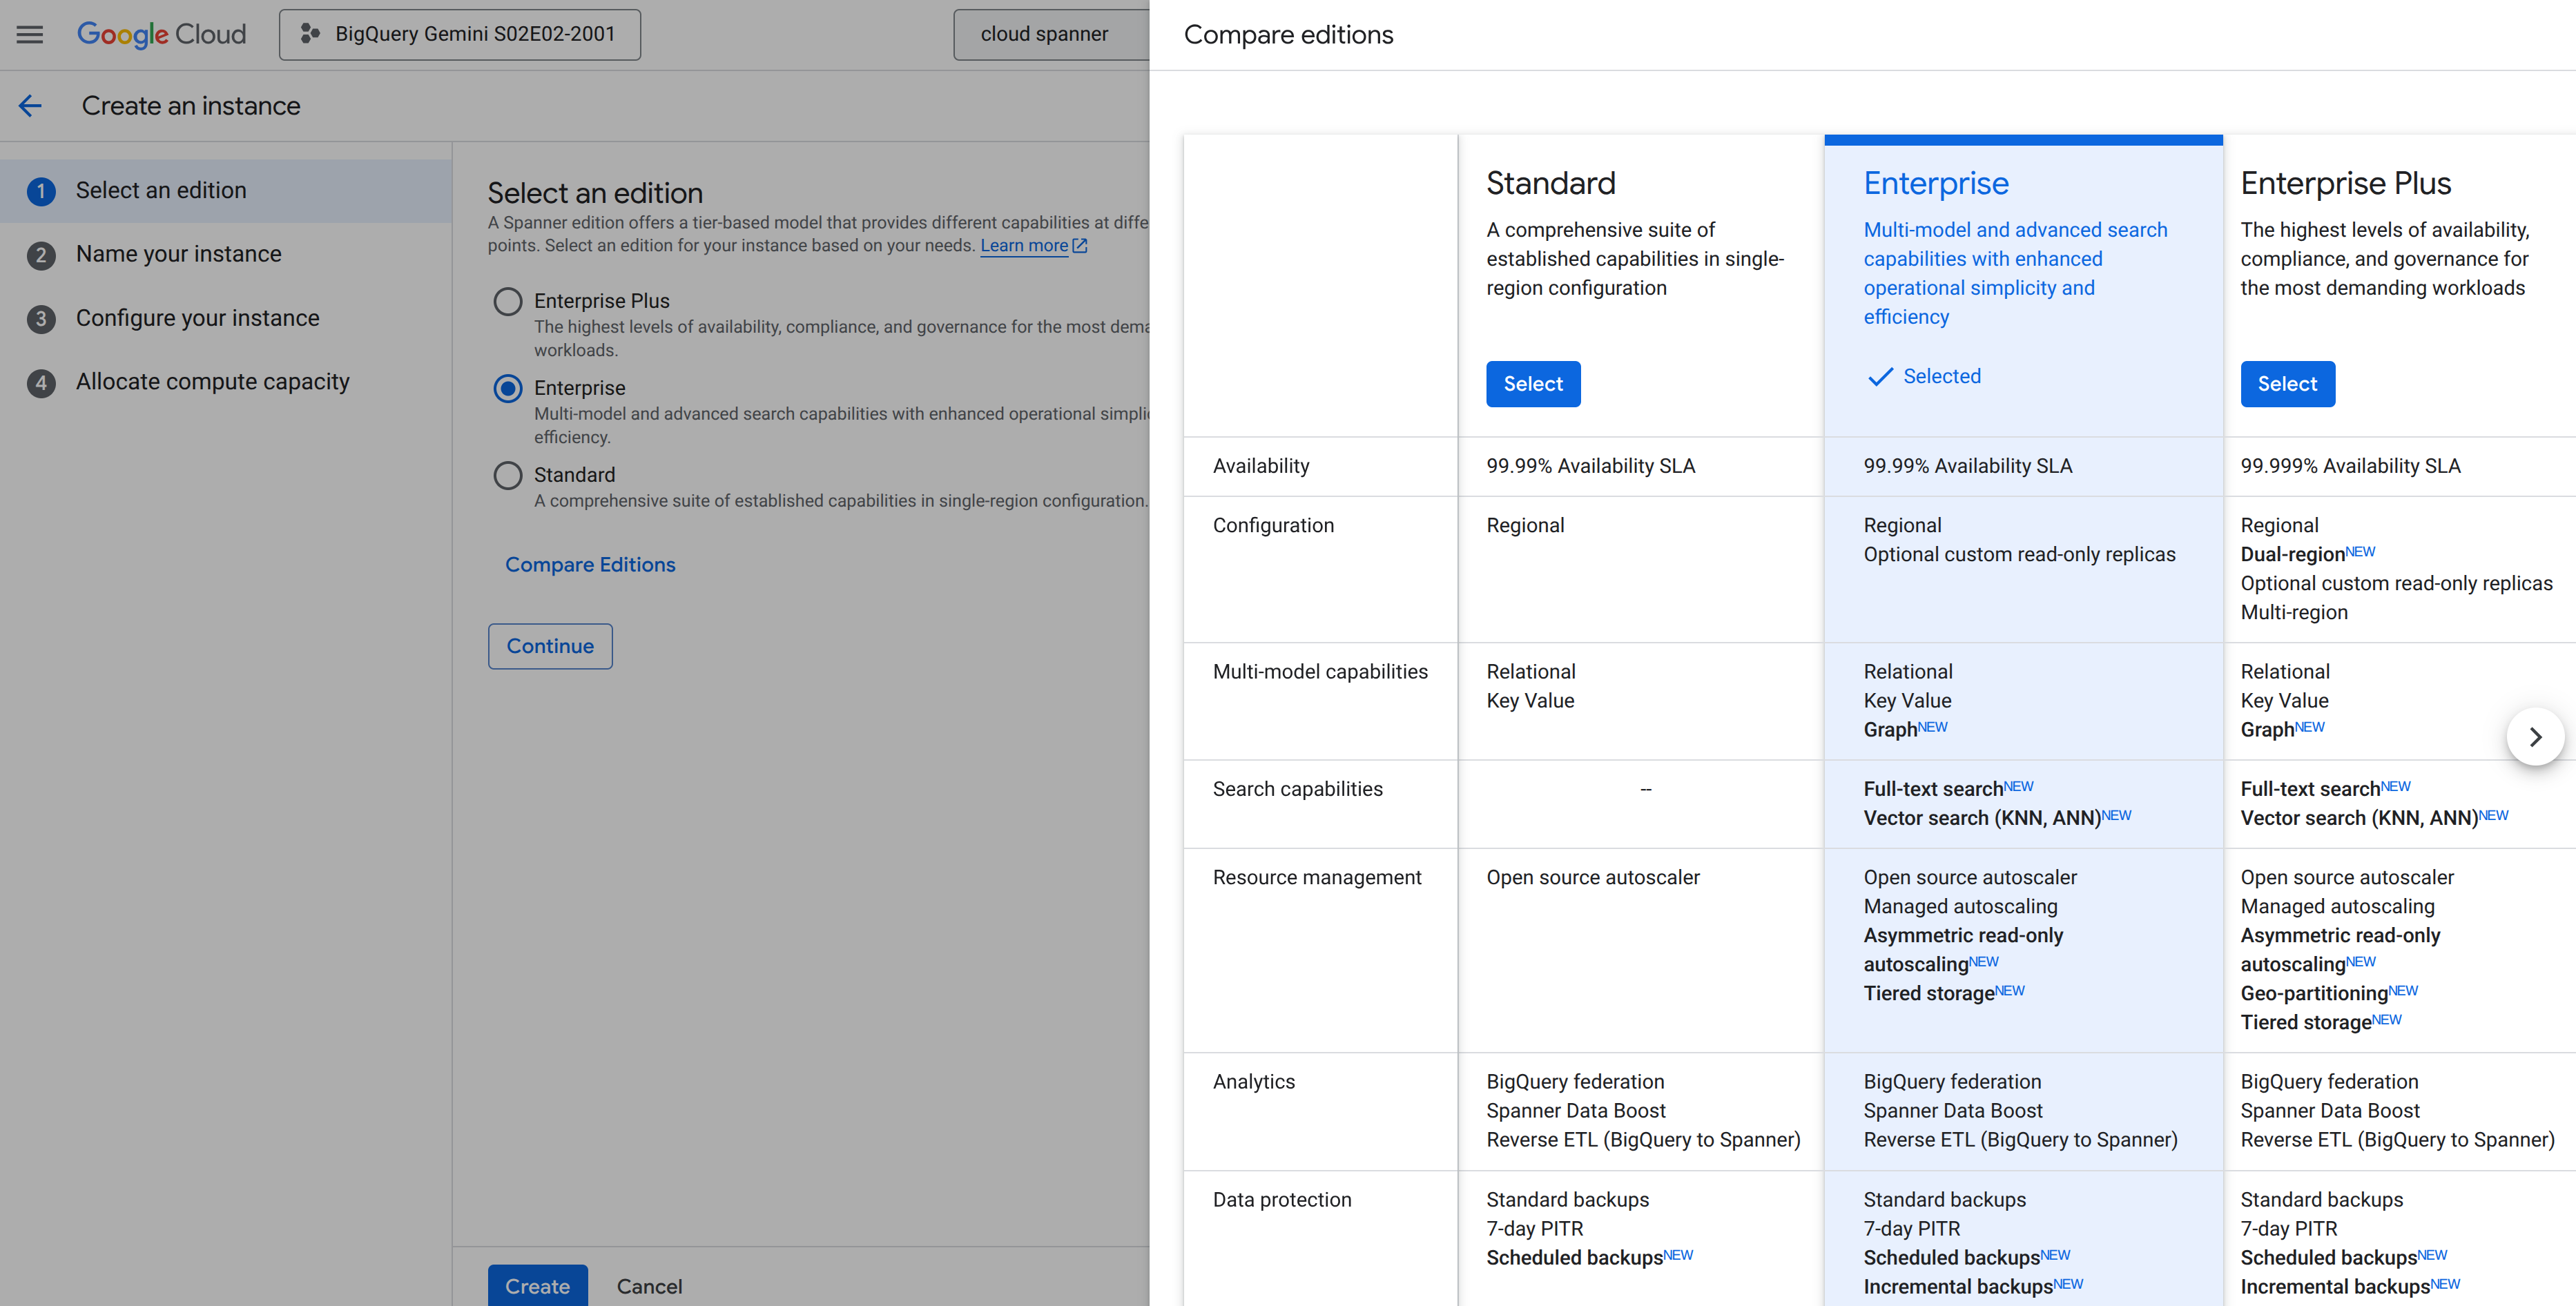

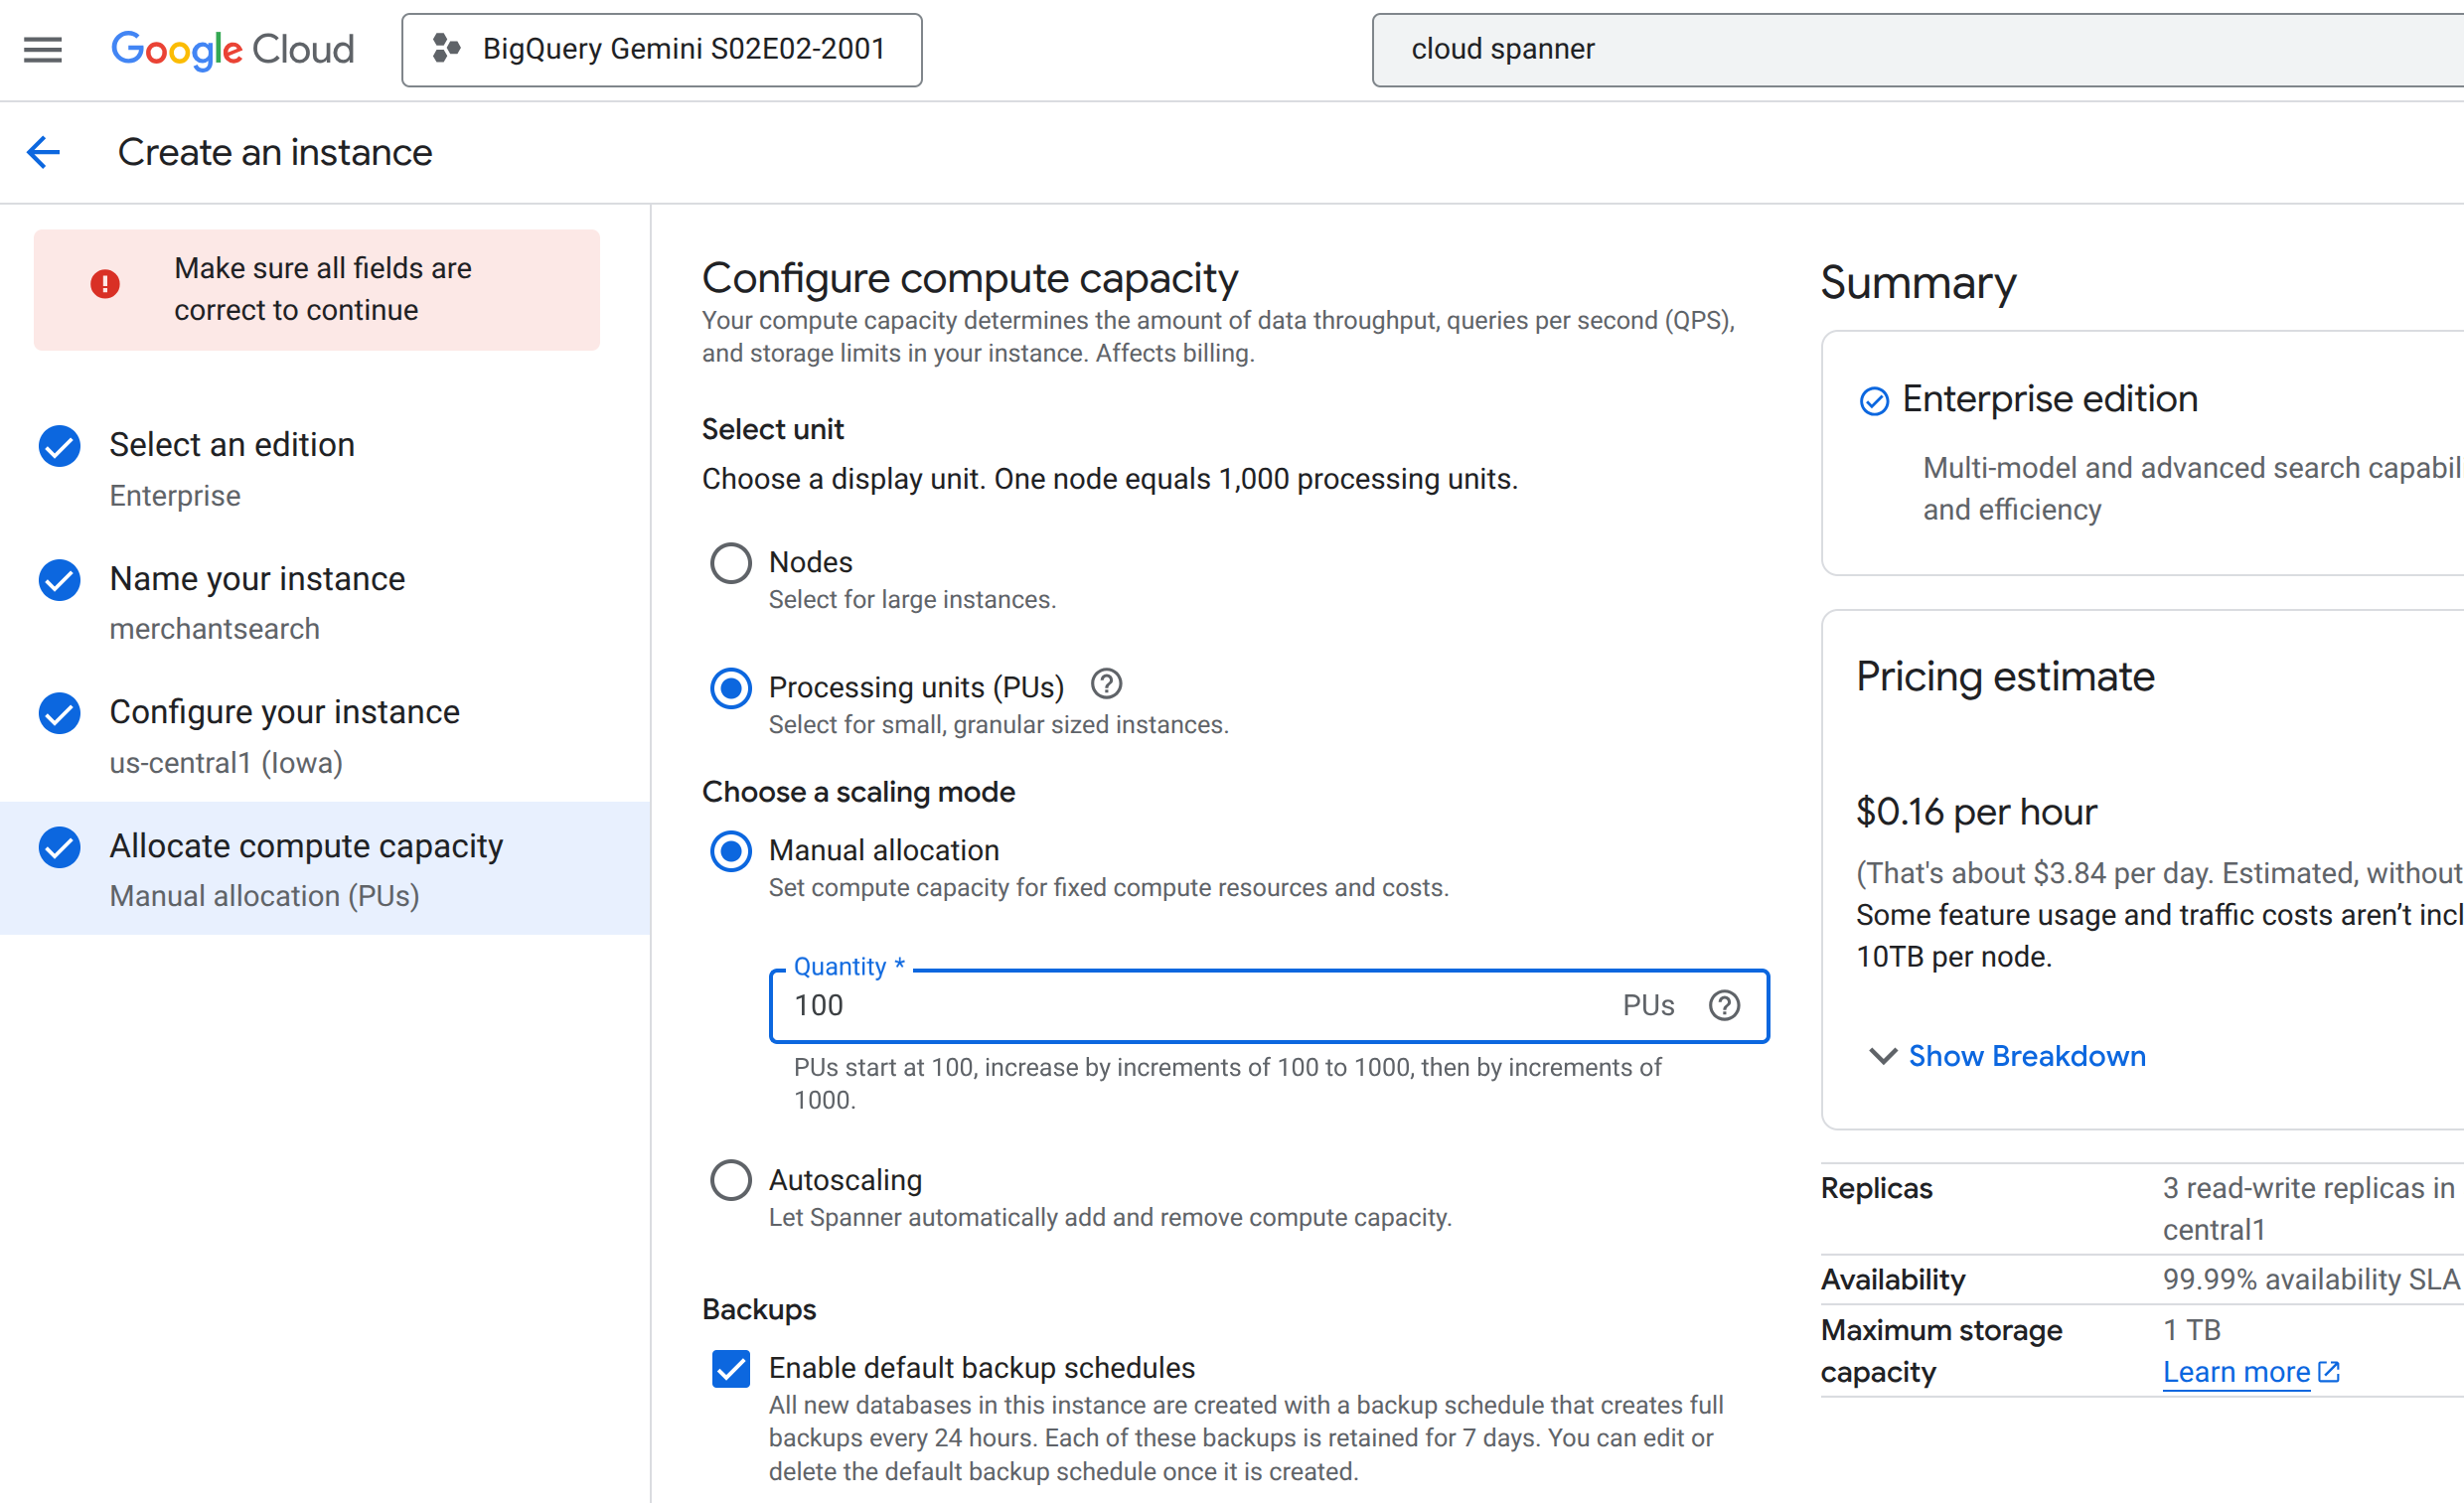

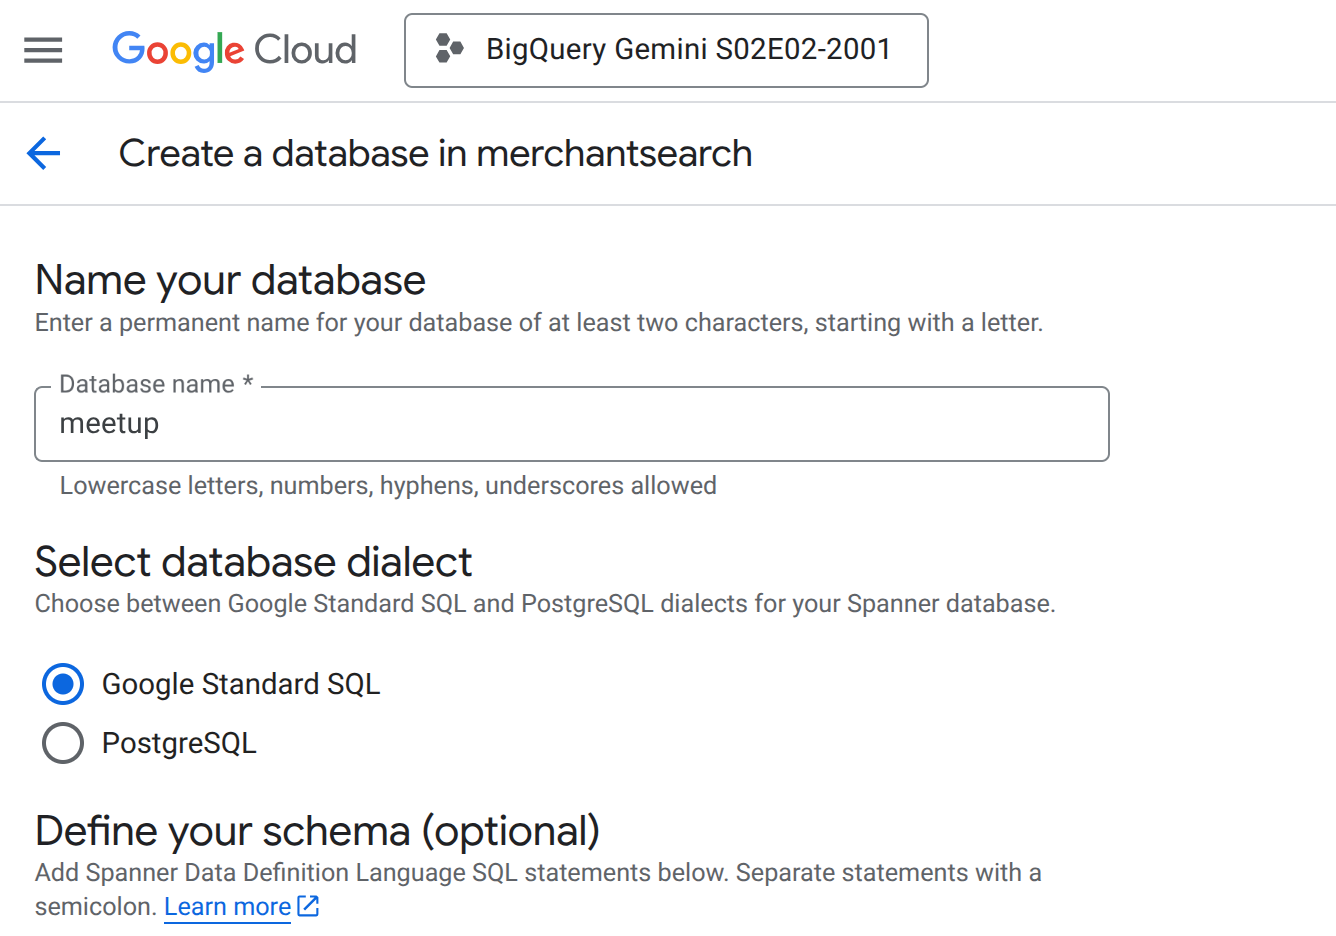

## 15.2 Go to Spanner Studio and create database objects

In [ ]:
DDL_TABLE="""CREATE TABLE products (
  product_id INT64,
  product_name STRING(MAX),
  description STRING(MAX),
  category STRING(MAX),
  price FLOAT64,

  -- Hidden Token Columns for Search
  product_name_tokens TOKENLIST AS (TOKENIZE_FULLTEXT(product_name)) HIDDEN,
  description_tokens TOKENLIST AS (TOKENIZE_FULLTEXT(description)) HIDDEN,
  category_tokens TOKENLIST AS (TOKEN(category)) HIDDEN,

  -- Hidden N-gram tokens for fuzzy search (e.g., 'app' matches 'apple')
  product_name_ngram_tokens TOKENLIST AS (TOKENIZE_SUBSTRING(product_name, ngram_size_min=>2, ngram_size_max=>3, relative_search_types=>['word_prefix', 'word_suffix'])) HIDDEN,

  -- Vector Column (3072 dimensions for gemini-embedding-001)
  product_embedding ARRAY<FLOAT32>(vector_length=>3072)
) PRIMARY KEY (product_id)"""

print(DDL_TABLE)

CREATE TABLE products (
  product_id INT64,
  product_name STRING(MAX),
  description STRING(MAX),
  category STRING(MAX),
  price FLOAT64,
  
  -- Hidden Token Columns for Search
  product_name_tokens TOKENLIST AS (TOKENIZE_FULLTEXT(product_name)) HIDDEN,
  description_tokens TOKENLIST AS (TOKENIZE_FULLTEXT(description)) HIDDEN,
  category_tokens TOKENLIST AS (TOKEN(category)) HIDDEN,
  
  -- Hidden N-gram tokens for fuzzy search (e.g., 'app' matches 'apple')
  product_name_ngram_tokens TOKENLIST AS (TOKENIZE_SUBSTRING(product_name, ngram_size_min=>2, ngram_size_max=>3, relative_search_types=>['word_prefix', 'word_suffix'])) HIDDEN,

  -- Vector Column (3072 dimensions for gemini-embedding-001)
  product_embedding ARRAY<FLOAT32>(vector_length=>3072)
) PRIMARY KEY (product_id)


In [ ]:
DDL_INDEX="""CREATE SEARCH INDEX products_search_idx
ON products(
  product_name_tokens,
  description_tokens,
  category_tokens,
  product_name_ngram_tokens
)
STORING (product_name, price, category)"""

print(DDL_INDEX)

CREATE SEARCH INDEX products_search_idx
ON products(
  product_name_tokens, 
  description_tokens, 
  category_tokens,
  product_name_ngram_tokens
)
STORING (product_name, price, category)


In [ ]:
DDL_VECTOR_INDEX="""CREATE VECTOR INDEX products_vector_search_idx
ON products(
    product_embedding
)
STORING (product_name, description, price)
OPTIONS(
    distance_type = 'COSINE',
    tree_depth = 2,
    num_leaves = 1000
)
"""

print(DDL_VECTOR_INDEX)

CREATE VECTOR INDEX products_vector_search_idx
ON products(
    product_embedding
)
STORING (product_name, description, price)
OPTIONS(
    'distance_type' = 'COSINE',
    'tree_depth' = 2
    'num_leaves' = 1000
)



In [ ]:
MODEL_REGION='us-central1'

In [ ]:
DDL_MODEL=f"""CREATE OR REPLACE MODEL EmbeddingsModel
INPUT(
  content STRING(MAX),
)
OUTPUT(
  embeddings STRUCT<statistics STRUCT<truncated BOOL, token_count FLOAT32>, values ARRAY<FLOAT32>>,
) REMOTE OPTIONS (
  endpoint = '//aiplatform.googleapis.com/projects/{GOOGLE_CLOUD_PROJECT}/locations/{MODEL_REGION}/publishers/google/models/gemini-embedding-001@default'
)"""

print(DDL_MODEL)

CREATE OR REPLACE MODEL EmbeddingsModel
INPUT(
  content STRING(MAX),
)
OUTPUT(
  embeddings STRUCT<statistics STRUCT<truncated BOOL, token_count FLOAT32>, values ARRAY<FLOAT32>>,
) REMOTE OPTIONS (
  endpoint = '//aiplatform.googleapis.com/projects/bq-gemini25waw-2001/locations/us-central1/publishers/google/models/gemini-embedding-001@default'
)


## 15. Create reservation

In [ ]:
SLOT_CAPACITY=100
EDITION="Enterprise"
SQL_REGION=f"region-{BIGQUERY_LOCATION}"
ASSIGNMENT_NAME=f"{BIGQUERY_RESERVATION_NAME}-{GOOGLE_CLOUD_PROJECT}"

In [ ]:
RAW_SQL=f"""
-- 1. Create the Reservation
CREATE RESERVATION `{GOOGLE_CLOUD_PROJECT}.{SQL_REGION}.{BIGQUERY_RESERVATION_NAME}`
OPTIONS (
  slot_capacity = {SLOT_CAPACITY},
  edition = '{EDITION}'
);

-- 2. Assign for Pipeline Jobs (Continuous Queries)
CREATE ASSIGNMENT `{GOOGLE_CLOUD_PROJECT}.{SQL_REGION}.{BIGQUERY_RESERVATION_NAME}.{ASSIGNMENT_NAME}-pipeline`
OPTIONS(
  assignee = 'projects/{GOOGLE_CLOUD_PROJECT}',
  job_type = 'PIPELINE'
);

-- 3. Assign for Standard Queries
CREATE ASSIGNMENT `{GOOGLE_CLOUD_PROJECT}.{SQL_REGION}.{BIGQUERY_RESERVATION_NAME}.{ASSIGNMENT_NAME}-query`
OPTIONS(
  assignee = 'projects/{GOOGLE_CLOUD_PROJECT}',
  job_type = 'QUERY'
);"""

print(RAW_SQL)


-- 1. Create the Reservation
CREATE RESERVATION `bq-gemini25waw-2001.region-us.bqmeetup`
OPTIONS (
  slot_capacity = 100,
  edition = 'Enterprise'
);

-- 2. Assign for Pipeline Jobs (Continuous Queries)
CREATE ASSIGNMENT `bq-gemini25waw-2001.region-us.bqmeetup.bqmeetup-bq-gemini25waw-2001-pipeline`
OPTIONS(
  assignee = 'projects/bq-gemini25waw-2001',
  job_type = 'PIPELINE'
);

-- 3. Assign for Standard Queries
CREATE ASSIGNMENT `bq-gemini25waw-2001.region-us.bqmeetup.bqmeetup-bq-gemini25waw-2001-query`
OPTIONS(
  assignee = 'projects/bq-gemini25waw-2001',
  job_type = 'QUERY'
);


## 16. Export embeddings (whole table - reverse ETL) to Cloud Spanner

In [ ]:
SPANNER_URI=f"https://spanner.googleapis.com/projects/{GOOGLE_CLOUD_PROJECT}/instances/{SPANNER_INSTANCE_ID}/databases/{SPANNER_DATABASE_ID}"
SPANNER_TABLE="products"
SPANNER_URI

'https://spanner.googleapis.com/projects/bq-gemini25waw-2001/instances/merchantsearch/databases/meetup'

In [ ]:
RAW_SQL=f"""EXPORT DATA OPTIONS (
  uri='{SPANNER_URI}',
  format='CLOUD_SPANNER',
  spanner_options=\"{{ 'table': '{SPANNER_TABLE}' }}\"
)
AS SELECT
  -- We select columns to match the Spanner Table Schema exactly
  product_id,
  product_name,
  description,
  category,
  price,
  -- BigQuery ARRAY<FLOAT64> maps to Spanner ARRAY<FLOAT32> (vector)
  product_embedding
FROM `{GOOGLE_CLOUD_PROJECT}.{BIGQUERY_DATASET_NAME}.products_indexed2`;"""

print(RAW_SQL)

EXPORT DATA OPTIONS (
  uri='https://spanner.googleapis.com/projects/bq-gemini25waw-2001/instances/merchantsearch/databases/meetup',
  format='CLOUD_SPANNER',
  spanner_options="{ 'table': 'products' }"
)
AS SELECT 
  -- We select columns to match the Spanner Table Schema exactly
  product_id,
  product_name,
  description,
  category,
  price,
  -- BigQuery ARRAY<FLOAT64> maps to Spanner ARRAY<FLOAT32> (vector)
  product_embedding
FROM `bq-gemini25waw-2001.meetup0202.products_indexed2`;


## 17. Search in  Cloud Spanner

### creating embedding for ... search query




In [ ]:
RAW_SQL=f"""
SELECT embeddings.values FROM ML.PREDICT(
    MODEL EmbeddingsModel,
    (SELECT "HEPA" as content)
)"""

print(RAW_SQL)


SELECT embeddings.values FROM ML.PREDICT(
    MODEL EmbeddingsModel,
    (SELECT "HEPA" as content)
)


### vector search

In [ ]:
RAW_SQL=f"""
SELECT product_name,
COSINE_DISTANCE(
product_embedding,
(
SELECT embeddings.values
FROM ML.PREDICT(
    MODEL EmbeddingsModel4,
    (SELECT "HEFA filter vacume" as content)
)
)
) as distance
FROM products
"""

print(RAW_SQL)

### fuzzy search

In [ ]:
RAW_SQL=f"""
SELECT *
FROM products
WHERE SEARCH_NGRAMS(product_name_ngram_tokens, 'filter')
"""

print(RAW_SQL)

### full text search

In [ ]:
RAW_SQL=f"""
select * from products
WHERE SEARCH(description_tokens, 'HEPA')
"""

print(RAW_SQL)

## 20. Drop reservations

In [ ]:
RAW_SQL=f"""

DROP ASSIGNMENT IF EXISTS `{GOOGLE_CLOUD_PROJECT}.{SQL_REGION}.{BIGQUERY_RESERVATION_NAME}.{ASSIGNMENT_NAME}-pipeline`;
DROP ASSIGNMENT IF EXISTS `{GOOGLE_CLOUD_PROJECT}.{SQL_REGION}.{BIGQUERY_RESERVATION_NAME}.{ASSIGNMENT_NAME}-query`;
DROP RESERVATION IF EXISTS `{GOOGLE_CLOUD_PROJECT}.{SQL_REGION}.{BIGQUERY_RESERVATION_NAME}`;

"""

print(RAW_SQL)



DROP ASSIGNMENT IF EXISTS `bq-gemini25waw-2001.region-us.bqmeetup.bqmeetup-bq-gemini25waw-2001-pipeline`;
DROP ASSIGNMENT IF EXISTS `bq-gemini25waw-2001.region-us.bqmeetup.bqmeetup-bq-gemini25waw-2001-query`;
DROP RESERVATION IF EXISTS `bq-gemini25waw-2001.region-us.bqmeetup`;




## 21. AI Search applications from BigQuery table